# Drowsiness Detection System

- Drowsy Driving is a deadly combination of driving and sleepiness. 

- The number of road accidents due to Drowsy Driving is increasing at an alarming rate worldwide. 

- Not having a proper sleep is the main reason behind drowsiness while driving. However, other reasons like sleep disorders, medication, alcohol consumption, or driving during night shifts can also cause drowsiness while driving.


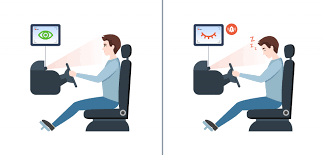

### You can see our project here : https://github.com/Ahmedsaed/Driver-Drowsiness-Detection

### Or the presentation here : https://docs.google.com/presentation/d/1AYDvPfrov1NOHs7tRiR54ip9F66pPQ85-A832dIKtTA/edit?usp=sharing

# Loading data and libraries

In [1]:
!pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 12.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires flatbuffers~=1.12.0, but you have flatbuffers 23.5.26 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4

In [2]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

# Image preprocessing : 
### our preprocessing will include
- Detecting faces from images
- Drawing landmarks on our images to increase performance
- Resizing our images 
- LabelEncoding
- Image Augmantation

# Landmarks :
We will use mediapipe to draw landmarks on our images after detecting faces and croping them

In [3]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [4]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )

 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE)) 
    return resized_array

In [5]:
imgH, imgW, _=0,0,0 
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
                            
     # Running inference using static_image_mode 
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:  
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [44]:
def face_for_yawn(direc="../input/drowsiness-prediction-dataset/0 FaceImages", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for indx, image in enumerate(os.listdir(path_link)):
          if indx in range(300):
            print(indx)
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [45]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
256


In [46]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
871


### Our images will be like this:

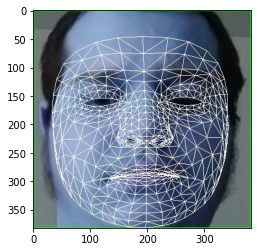

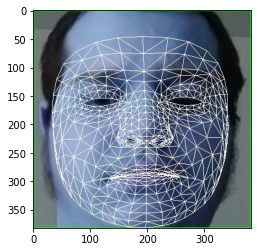

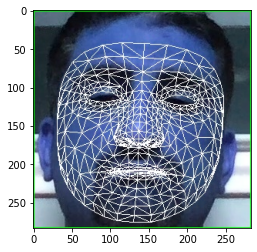

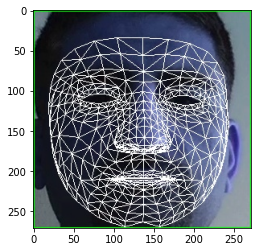

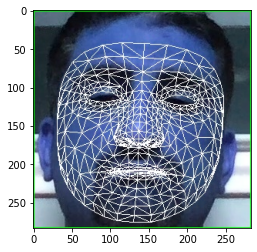

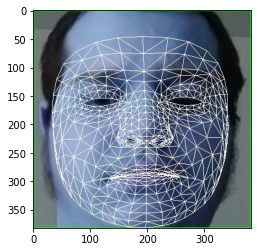

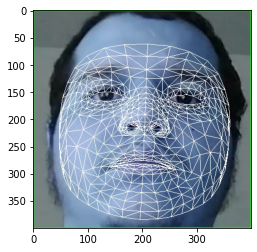

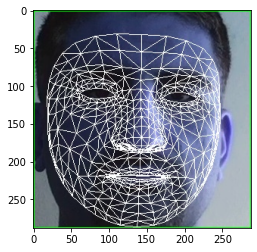

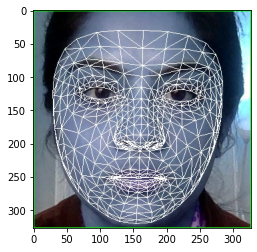

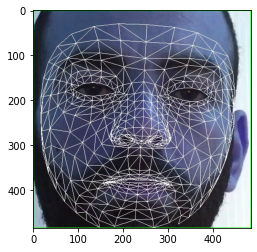

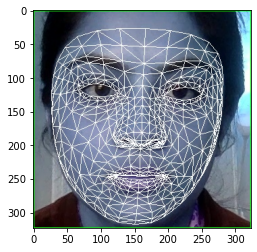

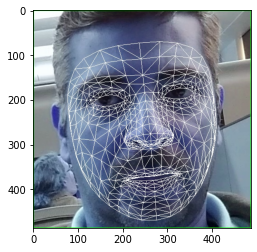

In [47]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

### Resizing images

In [48]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


## separate label and features

In [49]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

In [51]:
print(len(X))

1127


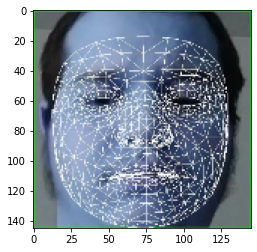

In [52]:
plt.imshow(X[5])

## Reshape the array

In [53]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [54]:
print(X.shape)

(1127, 145, 145, 3)


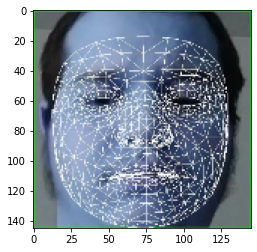

In [55]:
plt.imshow(X[5])

## LabelEncoder

In [56]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

In [57]:
print(y.shape)

(1127,)


# Splitting

In [58]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [59]:
len(X_test)

226

In [60]:
len(X_train)

901

### import some dependencies

In [61]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation

In [62]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [63]:
X_train.shape[1:]

(145, 145, 3)

In [64]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 143, 143, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 143, 143, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 71, 71, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 67, 67, 32)        12832     
_________________________________________________________________
batch_normalization_5 (Batch (None, 67, 67, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)       

In [65]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
29/29 [==============================] - 6s 186ms/step - loss: 0.4134 - accuracy: 0.8135 - val_loss: 0.5637 - val_accuracy: 0.8097
Epoch 2/70
29/29 [==============================] - 4s 150ms/step - loss: 0.3055 - accuracy: 0.8513 - val_loss: 0.4973 - val_accuracy: 0.8097
Epoch 3/70
29/29 [==============================] - 4s 148ms/step - loss: 0.2753 - accuracy: 0.8679 - val_loss: 0.7994 - val_accuracy: 0.8097
Epoch 4/70
29/29 [==============================] - 4s 150ms/step - loss: 0.2557 - accuracy: 0.8746 - val_loss: 0.5894 - val_accuracy: 0.8097
Epoch 5/70
29/29 [==============================] - 4s 146ms/step - loss: 0.2721 - accuracy: 0.8590 - val_loss: 0.5807 - val_accuracy: 0.8009
Epoch 6/70
29/29 [==============================] - 4s 146ms/step - loss: 0.2546 - accuracy: 0.8724 - val_loss: 0.5920 - val_accuracy: 0.7832
Epoch 7/70
29/29 [==============================] - 4s 146ms/step - loss: 0.2240 - accuracy: 0.8790 - val_loss: 0.5395 - val_accuracy: 0.7965
Epoch 

In [66]:
import pandas as pd

#history = model.fit(X_train, y_train, epochs=10)
history_df = pd.DataFrame(history.history)


In [67]:
history_df.to_csv('drowsiness_history.csv', index=False)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.413355,0.813541,0.563672,0.809735
1,0.305514,0.851276,0.497296,0.809735
2,0.275273,0.867925,0.799357,0.809735
3,0.255725,0.874584,0.589378,0.809735
4,0.272060,0.859046,0.580693,0.800885


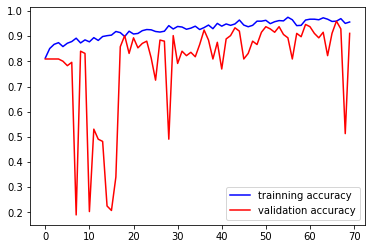

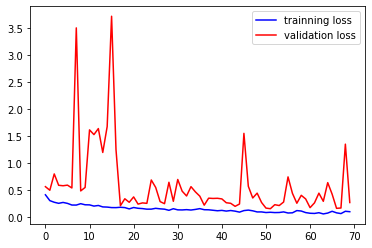

In [68]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [94]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
8/8 [==============================] - 0s 9ms/step - loss: 0.2702 - accuracy: 0.9115


{'loss': 0.270207941532135, 'accuracy': 0.9115044474601746}

In [ ]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

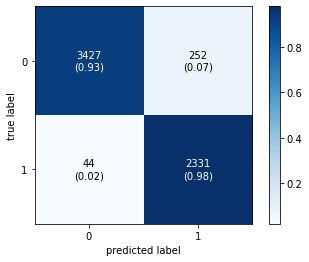

In [70]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [118]:
from sklearn.metrics import confusion_matrix
'''
y_true = y_test
y_pred = model.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
print(cm[1, 1])

#cm[0, 1], cm[1, 0], cm[0, 0]

'''
y_pred = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred.argmax(axis=1))
print(cm)
print(cm[0,1])


[[688   0]
 [213   0]]
0


In [113]:
y_pred = model.predict(X_test)
y_test

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0])

In [82]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('report.csv', index=False)
print(report)

{'0': {'precision': 0.8097345132743363, 'recall': 1.0, 'f1-score': 0.8948655256723717, 'support': 183}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 43}, 'accuracy': 0.8097345132743363, 'macro avg': {'precision': 0.40486725663716816, 'recall': 0.5, 'f1-score': 0.4474327628361858, 'support': 226}, 'weighted avg': {'precision': 0.6556699819876264, 'recall': 0.8097345132743363, 'f1-score': 0.7246035008763009, 'support': 226}}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualizing our CNN architecture

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(model)